In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

---

# Análisis para encontrar futuros targets

In [4]:
events = pd.read_pickle("../../../../data/tp2/events_tp2_formateado.pkl")

---

## Encontrando una distribución de horas

In [4]:
events["hora"] = events["date"].dt.hour

### Voy a contar una sola vez cada dispositivo en cada hora para evitar desbalanceo con dispositivos que tienen 10000 eventos en una hora

In [88]:
horas = events.groupby("hora").agg({"device_id":"nunique"}).rename(columns = {"device_id":"cant_dispositivos"})

In [88]:
horas.T

hora,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cant_dispositivos,66843,67141,67214,60303,52288,38412,25664,17020,11892,9328,...,39243,45240,56199,58664,63020,62221,62353,60238,61463,63172


### Uso franja de 4 horas

In [90]:
horas["franja"] = 0
horas.reset_index(inplace = True)

In [90]:
tam_franja = 4
hora_inicio = 0
hora_fin = tam_franja
for x in range(1,7):
    horas["franja"][(horas["hora"] >= hora_inicio) & (horas["hora"] < hora_fin)] = x
    hora_inicio += tam_franja  
    hora_fin = hora_inicio + tam_franja
    

In [92]:
horas = horas.groupby("franja").agg({"cant_dispositivos":["max","min","mean"],"hora":["min","max"],})

In [93]:
horas

cant_dispositivos                  hora    
                     max    min      mean  min max
franja                                            
1                  67214  60303  65375.25    0   3
2                  52288  17020  33346.00    4   7
3                  12814   9252  10821.50    8  11
4                  45240  19529  33516.00   12  15
5                  63020  56199  60026.00   16  19
6                  63172  60238  61806.50   20  23

---

## ¿Cúales son los eventos más frecuentes antes de una subasta? 
### ¿Hay algún top de eventos que compartan todos los dispositivos al menos una vez?

### Cargo datos de auctions

In [5]:
events = events[["date","event_id","kind","device_id","os_es_android"]]

In [2]:
auctions = pd.read_pickle("../../../../data/tp2/auctions_tp2_formateado.pkl")

In [3]:
auctions.drop(columns = ["source_id","ref_type_id"],inplace = True)

### Voy a utilizar merge_asof con 'events' como dataframe izquierdo con el metodo "foward": 
#### A “forward” search selects the first row in the right DataFrame whose ‘on’ key is greater than or equal to the left’s key.
### Voy a seleccionar para cada evento de dispositivo cual es la subasta con fecha mayor más cercana a ese evento

In [6]:
events.rename(columns = {"date":"date_event"},inplace = True)
auctions.rename(columns = {"date":"date_auction"},inplace = True)


In [7]:
auctions = pd.merge_asof(events,auctions,left_on = "date_event",
                     right_on = "date_auction",
                     by ="device_id", 
                     suffixes=("_event","_auction"),direction = "forward")

In [8]:
del events

##### Elimino las filas que no tuvieron subastas

In [9]:
auctions.dropna(inplace = True)

In [10]:
auctions.to_pickle("auctions_events")

In [11]:
auctions.head()

,date_event,event_id,kind,device_id,os_es_android,date_auction
0,2019-04-18 00:00:00.027,13,4.853173e+18,4314242242878368557,1,2019-04-19 22:01:29.840554
1,2019-04-18 00:00:00.071,158,8.370513e+18,2068670382964280534,0,2019-04-18 15:41:16.611443
3,2019-04-18 00:00:00.309,0,5.882882e+18,1329210878469536477,1,2019-04-24 14:21:51.244324
4,2019-04-18 00:00:00.486,2,6.168309e+18,5661732594213028190,1,2019-04-18 00:29:25.174955
5,2019-04-18 00:00:00.598,7,9.977660e+17,1725895739916434735,1,2019-04-18 00:15:17.221579


In [173]:
cant_event = auctions.groupby(["date_auction","event_id"]).agg({"date_event":"count"})
cant_events = cant_event.reset_index()["event_id"].value_counts()

### En total hay 450 eventos. ¿Con cuantos podemos quedarnos que abarquen la mayor cantidad de dispositivos? 

In [12]:
cant_event = auctions.groupby(["date_auction","event_id","kind"]).agg({"date_event":"count"})
cant_events = cant_event.reset_index()["event_id"].value_counts()

In [15]:
cant_kinds = cant_event.reset_index()["kind"].value_counts()

In [18]:
auctions["kind"].nunique()

447

In [19]:
auctions["event_id"].nunique()

449

### 10 Eventos principales que se dan antes de una subasta, ordenados por importancia

In [13]:
cant_events.head(10)

15     103047
23     101109
7       73239
0       47197
2       38669
1       30154
13      16845
101     15778
100     15539
245     14631
Name: event_id, dtype: int64

In [29]:
cant_kinds.head(10)

5.500848e+18    103047
6.081165e+18    101109
9.977660e+17     73239
5.882882e+18     47197
6.168309e+18     38669
4.017674e+18     30154
4.853173e+18     16845
6.897685e+18     15778
2.515470e+18     15539
9.066788e+18     14631
Name: kind, dtype: int64

#### El orden y valores de los kinds son iguales a los del ranking de events

### Cual es el porcentaje de dispositivos que queda representado quedandonos con los 5 eventos principales

In [155]:
eventos_principales = cant_events.index[:5]
a = auctions[ auctions["event_id"].isin(eventos_principales)]

In [156]:
a["device_id"].nunique() / auctions["device_id"].nunique() * 100

90.51972293437683

### Cual es el porcentaje de dispositivos que queda representado quedandonos con estos 10 eventos

In [160]:
eventos_principales = cant_events.index[:10]
a = auctions[ auctions["event_id"].isin(eventos_principales)]

In [161]:
a["device_id"].nunique() / auctions["device_id"].nunique() * 100

92.8450951288625

### Cual es el porcentaje de dispositivos que queda representado quedandonos con los 100 eventos principales

In [148]:
eventos_principales = cant_events.index[:100]
a = auctions[ auctions["event_id"].isin(eventos_principales)]

In [149]:
a["device_id"].nunique() / auctions["device_id"].nunique() * 100

99.02790896415239

---

## ¿Cómo es la distribución de eventos por día de semana y hora?

### El tiempo en segundos hasta que sea la hora más frecuente de uso por el usuario

In [58]:
events["hora"] = events["date"].dt.hour
events["dia_semana"] = events["date"].dt.dayofweek

In [59]:
e = events.groupby(["device_id","hora"]).agg({"date":"count"})


In [60]:
idx = e.groupby(["device_id"])["date"].transform(max) == e["date"]
e = e[idx]

In [61]:
hora_minima = e.reset_index().groupby("device_id").agg({"hora":"min"})

In [62]:
segundos_en_hora = 60*60

In [63]:
hora_minima["hora"] = hora_minima["hora"] * segundos_en_hora
hora_minima.rename(columns = {"hora":"segs_hasta_hora_freq"},inplace = True)

In [64]:
hora_minima.head()

,segs_hasta_hora_freq
device_id,
40621409780134,68400
41863526108385,18000
69039685746313,50400
90072729247980,64800
161514654074162,64800


### ¿Hay alguna diferencia en los horarios de uso entre semana y fin de semana ? 

In [80]:
events["dia"] = events["date"].dt.day
events_count = events.groupby( [pd.Grouper(key="date",freq="h"),"dia" ]).agg({"device_id":"nunique"}).reset_index()


In [85]:
heat = events_count.pivot("date","dia","device_id").reset_index()
heat["date"] = heat["date"].dt.hour  
heat = heat.groupby("date").agg("sum")

[Text(0.5, 0, 'Jueves'),
 Text(1.5, 0, 'Viernes'),
 Text(2.5, 0, 'Sabado'),
 Text(3.5, 0, 'Domingo'),
 Text(4.5, 0, 'Lunes'),
 Text(5.5, 0, 'Martes'),
 Text(6.5, 0, 'Miercoles'),
 Text(7.5, 0, 'Jueves'),
 Text(8.5, 0, 'Viernes')]

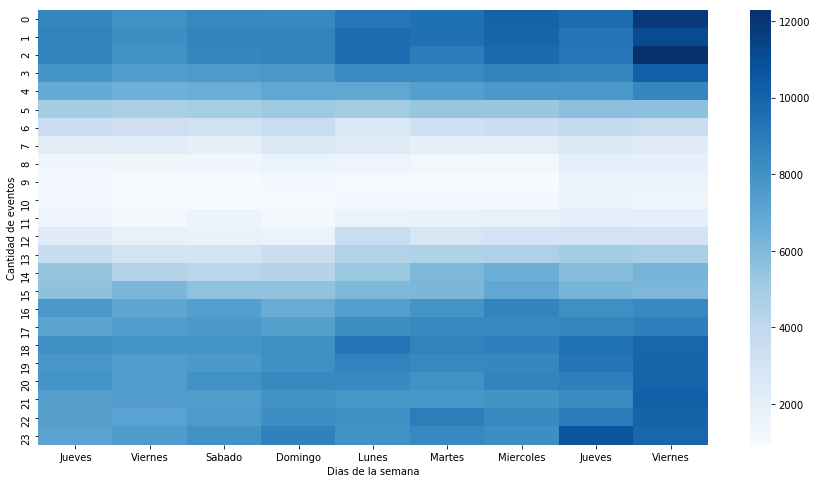

In [98]:
fig,ax = plt.subplots(figsize = (15,8))
sns.heatmap(heat,cmap = "Blues")
ax.set_xlabel("Dias de la semana")
ax.set_ylabel("Cantidad de eventos")
ax.set_xticklabels(["Jueves","Viernes","Sabado","Domingo","Lunes","Martes","Miercoles","Jueves","Viernes"])

### No se observa una diferencia en el uso frente a los días Sabado y Domingo

In [20]:
events.groupby(["device_id","dia_semana","hora"]).agg({"date":"count"}).head(10)

date
device_id      dia_semana hora      
40621409780134 1          15       3
               6          19       6
41863526108385 3          21      24
               4          5       78
               5          5       43
               6          2        8
69039685746313 1          17       4
               3          20       2
               4          14       6
                          18       3

# FIN ANALISIS

##### Propuesta: También se podrían usar otros criterios para definir importancia de eventos, por ejemplo filtrar entre eventos antes de una subasta o una conversión que es lo que nos importa

### ¿Podría usarse la aplicación más usada como feature ? ¿Quizás poniendo una etiqueta que nos diga el horario de uso de esa aplicación o qué día es más frecuente que la use?

### ¿Qué día de la semana es más frecuente un usuario? Quizás se puede mapear el día de la semana con un puntaje, dando menor peso a los días donde no apareció ninguna vez y más a los que apareció con más frecuencia, esto podría ayudarnos con ventanas en las que quizás no tenemos muchos datos de una persona pero sabemos que su día más frecuente esta dentro de los próximos por lo que tendría oportunidad de aparecer

In [5]:
events_red = events[["date","event_id","ref_hash","application_id","wifi"]]

In [7]:
events_red["dia_semana"] = events_red["date"].dt.dayofweek

/home/pelozo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
events_red.head()

,date,event_id,ref_hash,application_id,wifi,dia_semana
170092,2019-04-18 00:00:00.027,13,4314242242878368557,65,True,3
947821,2019-04-18 00:00:00.071,158,2068670382964280534,230,True,3
1724915,2019-04-18 00:00:00.102,15,726218951290512705,65,True,3
2794789,2019-04-18 00:00:00.309,0,1329210878469536477,263,False,3
5526010,2019-04-18 00:00:00.486,2,5661732594213028190,210,False,3


In [14]:
dias = events_red.groupby("ref_hash").agg({"dia_semana":"nunique"})

In [20]:
dias["dia_semana"].value_counts()

1    196733
2     73322
3     39092
4     23792
5     14656
6      8967
7      6057
Name: dia_semana, dtype: int64

### La gran mayoria son 1